# DD_NMROM_AE_testing
Notebook to test and visualize autoencoder performance.  
Author: Alejandro Diaz  
Date:   2/7/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
import scipy.sparse as sp
# import scipy.linalg as la
# from time import time
from utils.Burgers2D_probgen import Burgers2D
from utils.domain_decomposition import DD_FOM, DDFOM_data
from utils.lsrom import compute_bases_from_svd
# from IPython.display import HTML, Image
from utils.nmrom import DD_NMROM
import sys, os, torch
import dill as pickle

/usr/workspace/diaz64/anaconda/envs/opence-1.7.2-cuda-11.4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rc('font', size=20)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['text.usetex'] = True

In [3]:
# make directories for figures and data
data_dir = './data/'
fig_dir0 = './figures/'
for d in [data_dir, fig_dir0]:
    if not os.path.exists(d): os.mkdir(d)

## Set FOM parameters, initial condition

In [4]:
# parameters for physical domain and FD discretization
x_lim = [0, 1]
y_lim = [0, 1]
nx, ny    = 60, 60
viscosity = 1e-2

# number of subdomains in x and y directions
nsub_x, nsub_y = 2, 2
nsub = nsub_x*nsub_y

# time integration parameters
nt    = 1000
t_lim = [0, 2]
ht    = (t_lim[1]-t_lim[0])/nt

# parameter for initial condition
mu = 1.0

In [5]:
# parameterized initial conditions
def u0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

def v0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

## Initialize monolithic FOM and DD FOM

In [6]:
# initialize model
print('Initializing Burgers model...')
sys.stdout.flush()
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity)
print('Done!')

Initializing Burgers model...
Done!


In [7]:
# initialize DD FOM
ddfom = DD_FOM(fom, nsub_x, nsub_y)
ddfom.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

## Load FOM solution

In [8]:
ddfom_data = DDFOM_data(nx, ny, nt, viscosity, mu, nsub_x, nsub_y, data_dir)
ddfom_data.assemble_full_solution(ddfom)

## Build DD NM-ROM

In [13]:
# parameters for NM-ROM components
intr_size   = [4]*ddfom.n_sub#[5, 5]
intr_rnnz   = [5]*ddfom.n_sub#[5, 5]
intr_rshift = [5]*ddfom.n_sub#[5, 5]
intr_act    = ['Swish']*ddfom.n_sub#['Swish', 'Swish']
intr_loss   = ['RelMSE']*ddfom.n_sub#['AbsMSE', 'AbsMSE']
intr_batch  = [32]*ddfom.n_sub#[32, 32]
wd_intr     = 1e-6

intf_size   = [4]*ddfom.n_sub#[5, 5]
intf_rnnz   = [5]*ddfom.n_sub#[5, 5]
intf_rshift = [5]*ddfom.n_sub#[5, 5]
intf_act    = ['Swish']*ddfom.n_sub#['Swish', 'Swish']
intf_loss   = ['RelMSE']*ddfom.n_sub#['AbsMSE', 'AbsMSE']
intf_batch  = [32]*ddfom.n_sub#[32, 32]
wd_intf     = 1e-6

port_size   = [min(3, 2*len(ddfom.port_dict[p])) for p in ddfom.ports]
port_rnnz   = [5]*len(ddfom.ports)#[3]
port_rshift = [5]*len(ddfom.ports)#[5]
port_act    = ['Swish']*len(ddfom.ports)#['Swish']
port_loss   = ['RelMSE']*len(ddfom.ports)#['AbsMSE']
port_batch  = [32]*len(ddfom.ports)#[32, 32]
wd_port     = 1e-6

constraint_type = 'srpc'     # 'srpc' (strong rom-port constraints) or 'wfpc' (weak fom-port constraints)

# construct file and directory names for loading trained nets
net_dir = f'./trained_nets/nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/'

In [14]:
# load trained nets
intr_ae_list, intf_ae_list, port_ae_list = [], [], []
# wdstr = f'_wd{wd}' if wd > 0 else ''
for i in range(nsub):
    intr_file = f'ld_{intr_size[i]}_rnnz_{intr_rnnz[i]}_rshift_{intr_rshift[i]}_'  + \
                f'{intr_act[i]}_batch_{intr_batch[i]}_{intr_loss[i]}loss_wd{wd_intr}.p'
    intr_dir = net_dir+f'sub_{i+1}of{nsub}/interior/'
    intr_ae_list.append(torch.load(intr_dir+intr_file))

if constraint_type == 'wfpc':
    for i in range(nsub):
        intf_file = f'ld_{intf_size[i]}_rnnz_{intf_rnnz[i]}_rshift_{intf_rshift[i]}_'  + \
                    f'{intf_act[i]}_batch_{intf_batch[i]}_{intf_loss[i]}loss_wd{wd_intf}.p'
        intf_dir = net_dir+f'sub_{i+1}of{nsub}/interface/'
        intf_ae_list.append(torch.load(intf_dir+intf_file))
else:
    nports = len(ddfom.ports)
    for i in range(nports):
        port_file = f'ld_{port_size[i]}_rnnz_{port_rnnz[i]}_rshift_{port_rshift[i]}_'  + \
                    f'{port_act[i]}_batch_{port_batch[i]}_{port_loss[i]}loss_wd{wd_port}.p'
        port_dir = net_dir + f'port_{i+1}of{nports}/'
        port_ae_list.append(torch.load(port_dir+port_file))

In [15]:
# compute residual bases
ec_res     = 1e-16
nbasis_res = -1

res_bases = []
data_dir2 = data_dir + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/' 
for i in range(ddfom.n_sub):
    sub_dir  = data_dir2 + f'sub_{i+1}of{ddfom.n_sub}/'
    res_dict  = pickle.load(open(sub_dir  + f'residual_svd_data.p', 'rb'))
    res_bases.append(compute_bases_from_svd(res_dict, ec=ec_res, nbasis=nbasis_res))
    
    print(f'Subdomain {i}:')
    print(f'residual_basis.shape  = {res_bases[i].shape}')

Subdomain 0:
residual_basis.shape  = (1800, 55)
Subdomain 1:
residual_basis.shape  = (1800, 129)
Subdomain 2:
residual_basis.shape  = (1800, 160)
Subdomain 3:
residual_basis.shape  = (1800, 77)


In [16]:
# NM-ROM parameters
hr              = True       # set to True to employ hyper reduction
n_constraints   = 1          # number of constraints when using wfpc formulation
sample_ratio    = 1.4         # ratio of HR nodes to residual basis size
n_samples       = 360         # number of HR nodes to use. -1 uses sample_ratio
n_corners       = 240

ddnmrom = DD_NMROM(ddfom, 
                   intr_ae_list, 
                   intf_ae_list=intf_ae_list,
                   port_ae_list=port_ae_list, 
                   res_bases=res_bases,
                   constraint_type=constraint_type, 
                   hr=False,
                   sample_ratio=sample_ratio,
                   n_samples=n_samples,
                   n_corners=n_corners,
                   n_constraints=n_constraints, 
                   seed=0)
ddnmrom.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

In [17]:
ddnmromhr = DD_NMROM(ddfom, 
                   intr_ae_list, 
                   intf_ae_list=intf_ae_list,
                   port_ae_list=port_ae_list, 
                   res_bases=res_bases,
                   constraint_type=constraint_type, 
                   hr=True,
                   sample_ratio=sample_ratio,
                   n_samples=n_samples,
                   n_corners=n_corners,
                   n_constraints=n_constraints, 
                   seed=1)
ddnmromhr.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

In [18]:
ht = (t_lim[1]-t_lim[0])/nt
for i, s in enumerate(ddnmromhr.subdomain):
    wn_intr = np.random.rand(s.interior.romsize)
    wn_intf = np.random.rand(s.interface.romsize)
    
    wc_intr = np.random.rand(s.interior.romsize)
    wc_intf = np.random.rand(s.interface.romsize)  
    
    lam = np.random.rand(ddnmromhr.n_constraints)
    
    res, jac, H, rhs, Ag, Adg = ddnmrom.subdomain[i].res_jac(wn_intr, wn_intf, wc_intr, wc_intf, lam, ht)
    
    reshr,jachr,Hhr, rhshr, Ag, Adg = s.res_jac(wn_intr, wn_intf, wc_intr, wc_intf, lam, ht)
    
#     uv_intr = ddnmrom.subdomain[i].interior.decoder.fwd(wn_intr)
#     uv_intf = ddnmrom.subdomain[i].interface.decoder.fwd(wn_intf)
    uv_intr = s.interior.decoder.fwd(wn_intr)
    uv_intf = s.interface.decoder.fwd(wn_intf)
    
    uv_intr_hr = s.interior.subdecoder.fwd(wn_intr)
    uv_intf_hr = s.interface.subdecoder.fwd(wn_intf)
    
    print(f'Subdomain {i}:')
    print(f'Residual error = {np.linalg.norm(res[s.hr_nodes]-reshr)}')
    if constraint_type == 'srpc':
        jac=jac.tocsr()
        jachr=jachr.tocsr()
        print(f'Jacobian error = {sp.linalg.norm(jac[s.hr_nodes]-jachr)}')    
    else:
        print(f'Jacobian error = {np.linalg.norm(jac[s.hr_nodes]-jachr)}') 
    print(f'Intr. dec. err = {np.linalg.norm(uv_intr[s.interior.subdecoder.hr_nodes]-uv_intr_hr)}')
    print(f'Intf. dec. err = {np.linalg.norm(uv_intf[s.interface.subdecoder.hr_nodes]-uv_intf_hr)}')
    if constraint_type=='srpc':
        print(f'H error        = {np.linalg.norm(H.todense()-Hhr)/np.linalg.norm(H.todense())}')
    else:
        print(f'H error        = {np.linalg.norm(H-Hhr)/np.linalg.norm(H)}')
    print(f'RHS error      = {np.linalg.norm(rhs-rhshr)/np.linalg.norm(rhs)}\n')    

Subdomain 0:
Residual error = 0.0
Jacobian error = 2.822036308829876e-17
Intr. dec. err = 0.0
Intf. dec. err = 0.0
H error        = 0.0011392489257374856
RHS error      = 0.003972023317721747

Subdomain 1:
Residual error = 3.301747205575541e-17
Jacobian error = 1.4920374631934346e-17
Intr. dec. err = 1.5515838457795457e-17
Intf. dec. err = 0.0
H error        = 0.00018010326473951062
RHS error      = 0.00016142326532363915

Subdomain 2:
Residual error = 0.0
Jacobian error = 1.0273873087000773e-17
Intr. dec. err = 0.0
Intf. dec. err = 0.0
H error        = 0.00010584402666716878
RHS error      = 0.0006459946547103869

Subdomain 3:
Residual error = 4.0040395043000034e-17
Jacobian error = 1.3115977728313673e-17
Intr. dec. err = 3.4170089680666066e-17
Intf. dec. err = 0.0
H error        = 0.0011978095268424173
RHS error      = 0.0015952261396753329



In [19]:
for i, s in enumerate(ddnmromhr.subdomain):
    vec = np.random.rand(ddnmrom.subdomain[i].interior.fomsize)
    vechr = vec[s.interior.v.state_nodes]
    
    ruv = ddnmrom.subdomain[i].interior.I@vec
    ruv = ruv[s.interior.u.res_nodes]
    
    ruv3 = ddnmrom.subdomain[i].interior.I[np.ix_(s.interior.u.res_nodes, s.interior.v.state_nodes)]@vechr
    ruvhr = s.interior.u.Io@vechr
    
    print(f'Error 1 = {np.linalg.norm(ruv-ruvhr)}')
    print(f'Error 2 = {np.linalg.norm(ruv3-ruvhr)}')    

Error 1 = 0.0
Error 2 = 0.0
Error 1 = 0.0
Error 2 = 0.0
Error 1 = 0.0
Error 2 = 0.0
Error 1 = 0.0
Error 2 = 0.0


In [20]:
march=2
w_intr, w_intf, u_intr, v_intr, u_intf, v_intf, u_full, v_full, lam, runtime, flag=\
ddnmromhr.solve([0, t_lim[1]/nt*march], march, tol=1e-3, maxit=12, print_hist=False)

TypeError: solve() missing 1 required positional argument: 'guess'

In [21]:
Ax_fom = np.zeros(ddfom.n_constraints)
Ax_rom = np.zeros(ddnmrom.n_constraints)

intr_err = []
intf_err = []

UU_enc = np.zeros((nt+1, fom.nxy))
VV_enc = np.zeros((nt+1, fom.nxy))

for i, s in enumerate(ddnmrom.subdomain):
    intr = np.hstack([ddfom_data.subdomain[i].interior.u, ddfom_data.subdomain[i].interior.v])
    intf = np.hstack([ddfom_data.subdomain[i].interface.u, ddfom_data.subdomain[i].interface.v])
    
    intr_recon = s.interior.decoder.fwd(s.interior.encoder.fwd(intr))
    intf_recon = s.interface.decoder.fwd(s.interface.encoder.fwd(intf))
    
    intr_err.append(np.sqrt(np.sum(np.square(intr-intr_recon),1)))
    intf_err.append(np.sqrt(np.sum(np.square(intf-intf_recon),1)))
    
    UU_enc[:, s.interior.indices] = intr_recon[:,:s.interior.fomsize]
    VV_enc[:, s.interior.indices] = intr_recon[:,s.interior.fomsize:]
    
    UU_enc[:, s.interface.indices] = intf_recon[:,:s.interface.fomsize]
    VV_enc[:, s.interface.indices] = intf_recon[:,s.interface.fomsize:]
    Ax_fom += ddfom.subdomain[i].constraint_mat@s.interface.decoder.fwd(s.interface.encoder.fwd(intf[100]))
    
    if constraint_type=='srpc':
        Ax_rom += s.constraint_mat@s.interface.encoder.fwd(intf[0])
    else:
        Ax_rom += s.constraint_mat@s.interface.decoder.fwd(s.interface.encoder.fwd(intf[0]))
        
    
    print(f'Subdomain {i+1}:')
    print(f'Min interior recon. error  = {intr_err[i].min()}')
    print(f'Max interior recon. error  = {intr_err[i].max()}\n')
    
    print(f'Min interface recon. error = {intf_err[i].min()}')  
    print(f'Max interface recon. error = {intf_err[i].max()}\n')    

UU_enc=UU_enc.reshape((nt+1, nx, ny))
UU_enc=VV_enc.reshape((nt+1, nx, ny))

print(f'FOM constraint norm = {np.linalg.norm(Ax_fom)}')
print(f'{constraint_type} constraint norm = {np.linalg.norm(Ax_rom)}')

Subdomain 1:
Min interior recon. error  = 0.012018090549125773
Max interior recon. error  = 0.2341878427357131

Min interface recon. error = 0.0010524692778252206
Max interface recon. error = 0.05498467631917495

Subdomain 2:
Min interior recon. error  = 0.006128173002896114
Max interior recon. error  = 0.03869407594212655

Min interface recon. error = 0.003466291491789495
Max interface recon. error = 0.04434132481635542

Subdomain 3:
Min interior recon. error  = 0.007428116975872365
Max interior recon. error  = 0.05357420209966246

Min interface recon. error = 0.0030898120489416276
Max interface recon. error = 0.03333187686228453

Subdomain 4:
Min interior recon. error  = 0.009975832682754123
Max interior recon. error  = 0.04977010477934484

Min interface recon. error = 0.0033050142334797444
Max interface recon. error = 0.012234198925171766

FOM constraint norm = 0.0
srpc constraint norm = 0.0


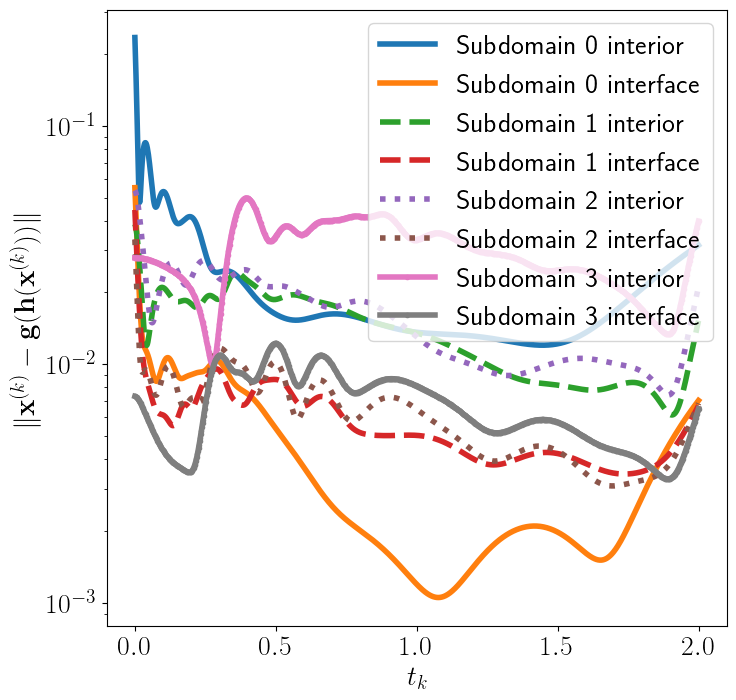

In [22]:
tt = np.linspace(t_lim[0], t_lim[1], nt+1)
ls = ['-', '--', ':', '.-']
plt.figure(figsize=(8,8))
for i in range(ddfom.n_sub):
    plt.semilogy(tt, intr_err[i], ls[i], label=f'Subdomain {i} interior')
    plt.semilogy(tt, intf_err[i], ls[i], label=f'Subdomain {i} interface')
plt.xlabel('$t_k$')
plt.ylabel('$\|\mathbf{x}^{(k)}-\mathbf{g}(\mathbf{h}(\mathbf{x}^{(k)}))\|$')
ymin = np.min([e.min() for e in intr_err + intf_err])
ymax = np.max([e.max() for e in intr_err + intf_err])
plt.legend()
plt.show()

In [23]:
for i, s in enumerate(ddnmromhr.subdomain):
    print(f'Sub {i+1} interior rom size = {s.interior.romsize}')    
    print(f'Sub {i+1} interface rom size = {s.interface.romsize}')

Sub 1 interior rom size = 4
Sub 1 interface rom size = 12
Sub 2 interior rom size = 4
Sub 2 interface rom size = 12
Sub 3 interior rom size = 4
Sub 3 interface rom size = 12
Sub 4 interior rom size = 4
Sub 4 interface rom size = 12


## Plot snapshots of solution

In [ ]:
# frame updater for animation
umin = np.min([s.interior.u.min() for s in ddfom_data.subdomain]+
              [s.interface.u.min() for s in ddfom_data.subdomain])
umax = np.max([s.interior.u.max() for s in ddfom_data.subdomain]+
              [s.interface.u.max() for s in ddfom_data.subdomain])
vmin = np.min([s.interior.v.min() for s in ddfom_data.subdomain]+
              [s.interface.v.min() for s in ddfom_data.subdomain])
vmax = np.max([s.interior.v.max() for s in ddfom_data.subdomain]+
              [s.interface.v.max() for s in ddfom_data.subdomain])

X, Y = np.meshgrid(fom.xx, fom.yy)
def update_frame(i, Z, zmin, zmax, cb_label):
    plt.clf()
    plt.pcolormesh(X, Y, Z[i], cmap='viridis', shading='auto', vmin=zmin, vmax=zmax) 
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$t_{'+f'{i:4d}'+'}' + f'={ht*i+t_lim[0]:1.4f}$')
    cb = plt.colorbar(orientation='vertical', label=cb_label)
    return plt

In [ ]:
frame = 900
print('Encoded FOM solution:')
update_frame(frame, UU_enc, umin, umax, '$u(t, x, y)$')
plt.show()

print('Original FOM solution:')
update_frame(frame, ddfom_data.UU, umin, umax, '$u(t, x, y)$')
plt.show()

print('Pointwise error:')
perror = np.abs(UU_enc-ddfom_data.UU)#/np.abs(ddfom_data.UU.max())
update_frame(frame, perror, perror.min(), perror.max(), '$u(t, x, y)$')
plt.show()

## Sandbox

In [27]:
c = False
np.abs(-1 if c else 2)

2

In [ ]:
ddnmrom.subdomain[1].interior.encoder.scale

In [ ]:
y.type()